In [2]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from config import C_COMMON, C_SINGLE, C_GRID
#others
from xgboost import XGBRegressor
import time

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
# from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES
from math import pi as PI

In [6]:
df = pd.read_csv(
    '/home/yusukemh/sadow_lts/personal/yusukemh/pi_casc/processed_datasets/dataset_6grid.csv',
    usecols=C_SINGLE + ['data_in', 'season_wet', 'elevation', 'year', 'month', 'lat', 'lon', 'skn']
)

In [13]:
len(df['skn'].unique()) -  sum(df.groupby('skn').size() < 5)

1944

In [33]:
columns = C_SINGLE + ['season_wet', 'elevation', 'lat', 'lon']

In [34]:
excluded_skns = []
df_result = []
num_groups = df['skn'].unique().shape[0]
for i, (skn, group) in enumerate(df.groupby('skn')):
    if group.shape[0] < 5:
        excluded_skns.append(skn)
        continue
    group.sort_values(by=['year', 'month'], inplace=True) 
    
    X = np.array(group[columns])
    Y = np.array(group['data_in'])
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group['prediction_multi_linear'] = y_pred
    df_result.append(group)
    
    print(f'{i}/{num_groups}', end='\r')
    

In [35]:
df_multi_linear = pd.concat(df_result).sort_index()

In [36]:
rmse_multi_linear = mean_squared_error(df_multi_linear['data_in'], df_multi_linear['prediction_multi_linear'], squared=False)

In [37]:
rmse_multi_linear

4.310378524355613

In [40]:
xgboost = XGBRegressor(
    n_estimators=240,
    learning_rate=0.0552212149966506,
    max_depth=9,
    verbosity=0,
    n_jobs=-1,
    subsample=0.9,
    seed=np.random.randint(200)
)
df_result_xgb = []
for i, (skn, group) in enumerate(df.groupby('skn')):
    if group.shape[0] < 5:
        excluded_skns.append(skn)
        continue
    group.sort_values(by=['year', 'month'], inplace=True)   
    
    X = np.array(group[columns])
    Y = np.array(group['data_in'])
    
    y_pred = cross_val_predict(xgboost, X, Y, cv=5, n_jobs=-1)
    
    group['prediction_multi_xgb'] = y_pred
    df_result_xgb.append(group)
    
    print(f'{i}/{num_groups}', end='\r')

In [43]:
pd.concat(df_result_xgb).to_csv('04/site_specific_xgb_prediction.csv')

# append LR result

In [46]:
df_xgb = pd.read_csv('04/site_specific_xgb_prediction.csv')[['skn', 'year', 'month', 'prediction_multi_xgb', 'data_in']]

In [52]:
df_result_lr = []
for i, (skn, group) in enumerate(df.groupby('skn')):
    if group.shape[0] < 5:
        continue
    group.sort_values(by=['year', 'month'], inplace=True)   
    
    X = np.array(group[columns])
    Y = np.array(group['data_in'])
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group['prediction_multi_lr'] = y_pred
    df_result_lr.append(group)
    
    print(f'{i}/{num_groups}', end='\r')

In [53]:
df_lr = pd.concat(df_result_lr)[['skn', 'year', 'month', 'prediction_multi_lr', 'data_in']]

In [54]:
df_result_combined = pd.merge(
    left=df_xgb,
    right=df_lr,
    on=['skn', 'year', 'month', 'data_in']
)

In [56]:
df_result_combined.to_csv('04/site_specific_result.csv')

# visualize

In [3]:
df_result = pd.read_csv('04/site_specific_result.csv')

In [5]:
rmse_per_station_linear = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_multi_lr'], squared=False))
rmse_per_station_xgb = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_multi_xgb'], squared=False))
n_data = df_result.groupby(by="skn").size()
df_rmse = pd.DataFrame({"n_data": n_data, "rmse_linear": rmse_per_station_linear, "rmse_xgb": rmse_per_station_xgb})
df_rmse['diff'] = df_rmse['rmse_linear'] - df_rmse['rmse_xgb']

rmse_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_lr'], squared=False)
rmse_xgb = mean_squared_error(df_result['data_in'], df_result['prediction_multi_xgb'], squared=False)

print("RMSE using site-specific Linear Regression models: {:.3f}".format(rmse_linear))
print("RMSE using a sigle XGBost model: {:.3f}".format(rmse_xgb))

RMSE using site-specific Linear Regression models: 4.309
RMSE using a sigle XGBost model: 4.150


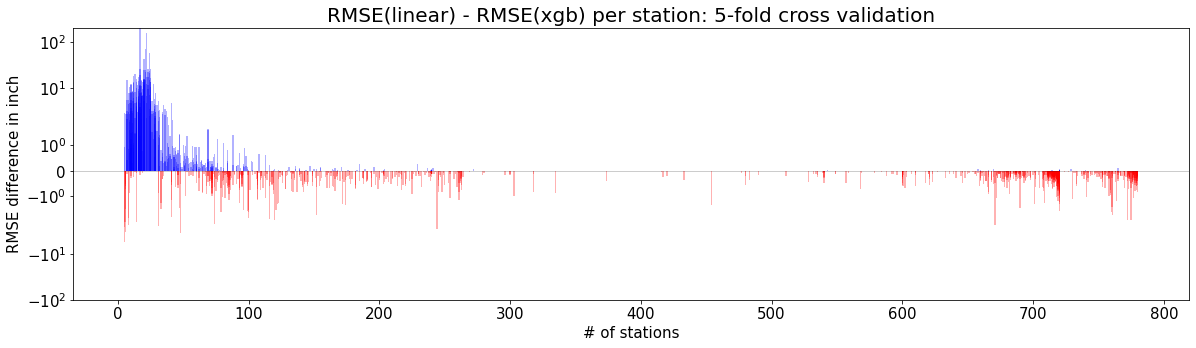

In [4]:
fig, ax = plt.subplots(1, figsize=(20,5))
ax.bar(
    x=df_rmse['n_data'],
    height=df_rmse['diff'],
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_rmse['diff']],
    alpha=0.3
)


ax.set_ylim((-100, 200))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.set_xlabel('# of stations', fontsize=15)
ax.set_ylabel('RMSE difference in inch', fontsize=15)

    
ax.set_title("RMSE(linear) - RMSE(xgb) per station: 5-fold cross validation", fontsize=20)
ax.set(yscale='symlog')
ax.tick_params(labelsize=15)# increase the ticklabel size for both axis

print()
# fig.savefig('plots/05_site_specific_all_stations')